# 11 - Spatial Clustering Analysis

This notebook performs K-Means clustering to identify seismic zones in Turkey.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score
import os, sys, warnings
warnings.filterwarnings('ignore')

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd()), 'src'))
from config import *
from visualization import setup_style, create_turkey_basemap
setup_style()

OUTPUT_DIR = os.path.join(FIGURES_PATH, '11_clustering')
os.makedirs(OUTPUT_DIR, exist_ok=True)

eq_df = pd.read_csv(os.path.join(DATA_PROCESSED, 'earthquakes_processed.csv'))
eq_df['date'] = pd.to_datetime(eq_df['date'], format='mixed')

# Use significant earthquakes for clustering
earthquakes = eq_df[eq_df['magnitude'] >= 4.0].copy()
print(f"Earthquakes for clustering: {len(earthquakes):,}")

Earthquakes for clustering: 4,103


In [2]:
# Prepare features for clustering
features = earthquakes[['latitude', 'longitude', 'depth', 'magnitude']].dropna()
X = features.values

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Features shape: {X_scaled.shape}")

Features shape: (4103, 4)


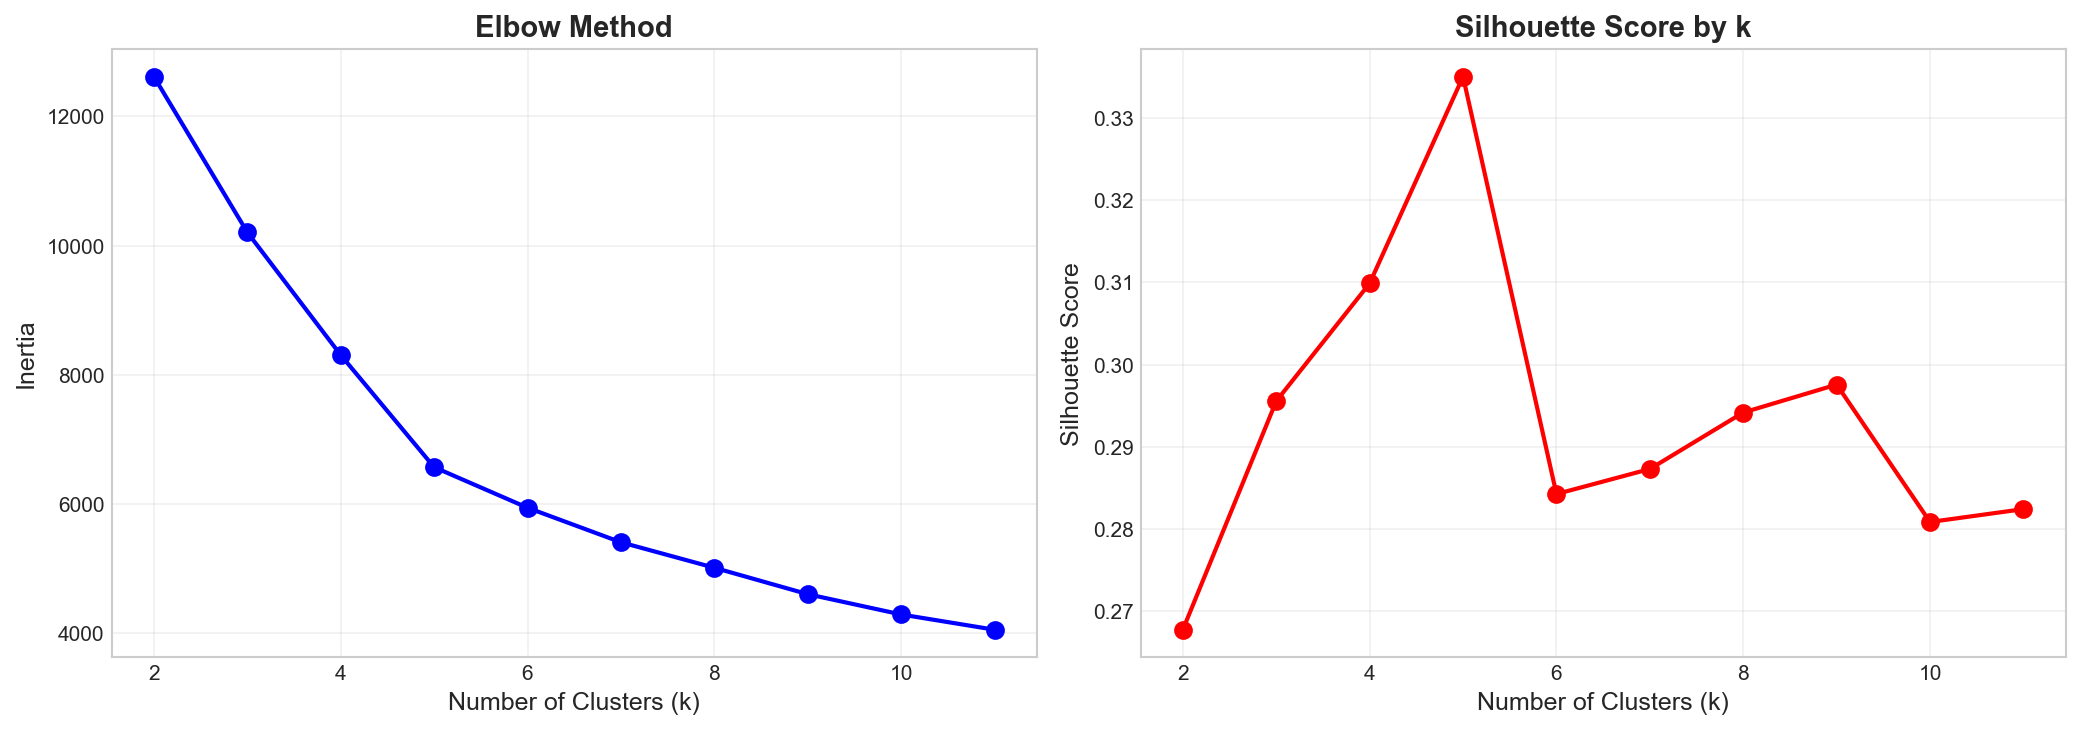


Optimal k (highest silhouette): 5


In [3]:
# Elbow method to find optimal k
k_range = range(2, 12)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
ax1.plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method', fontweight='bold')
ax1.grid(alpha=0.3)

ax2 = axes[1]
ax2.plot(k_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score by k', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'elbow_silhouette.png'), dpi=150, bbox_inches='tight')
plt.show()

optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"\nOptimal k (highest silhouette): {optimal_k}")

In [4]:
# Apply K-Means with optimal k
k = 6  # Using 6 clusters for good interpretability
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
features['cluster'] = kmeans.fit_predict(X_scaled)

# Evaluation metrics
silhouette = silhouette_score(X_scaled, features['cluster'])
davies_bouldin = davies_bouldin_score(X_scaled, features['cluster'])

print(f"K-Means Clustering (k={k}):")
print(f"  Silhouette Score: {silhouette:.4f}")
print(f"  Davies-Bouldin Index: {davies_bouldin:.4f}")

K-Means Clustering (k=6):
  Silhouette Score: 0.2843
  Davies-Bouldin Index: 1.0793


In [5]:
# Cluster statistics
cluster_stats = features.groupby('cluster').agg({
    'latitude': ['mean', 'count'],
    'longitude': 'mean',
    'depth': ['mean', 'std'],
    'magnitude': ['mean', 'max']
}).round(2)
cluster_stats.columns = ['lat_center', 'count', 'lon_center', 'depth_mean', 'depth_std', 'mag_mean', 'mag_max']

print("\nCluster Statistics:")
cluster_stats


Cluster Statistics:


,lat_center,count,lon_center,depth_mean,depth_std,mag_mean,mag_max
cluster,,,,,,,
0,39.31,797,41.70,11.06,6.11,4.23,4.9
1,36.30,152,29.46,54.91,22.95,4.42,6.1
2,36.87,841,27.79,12.93,7.52,4.23,5.0
3,38.58,448,34.82,11.97,6.71,5.20,7.7
4,39.81,888,29.06,11.42,6.66,4.22,4.9
5,37.72,977,37.80,9.56,4.95,4.24,5.0


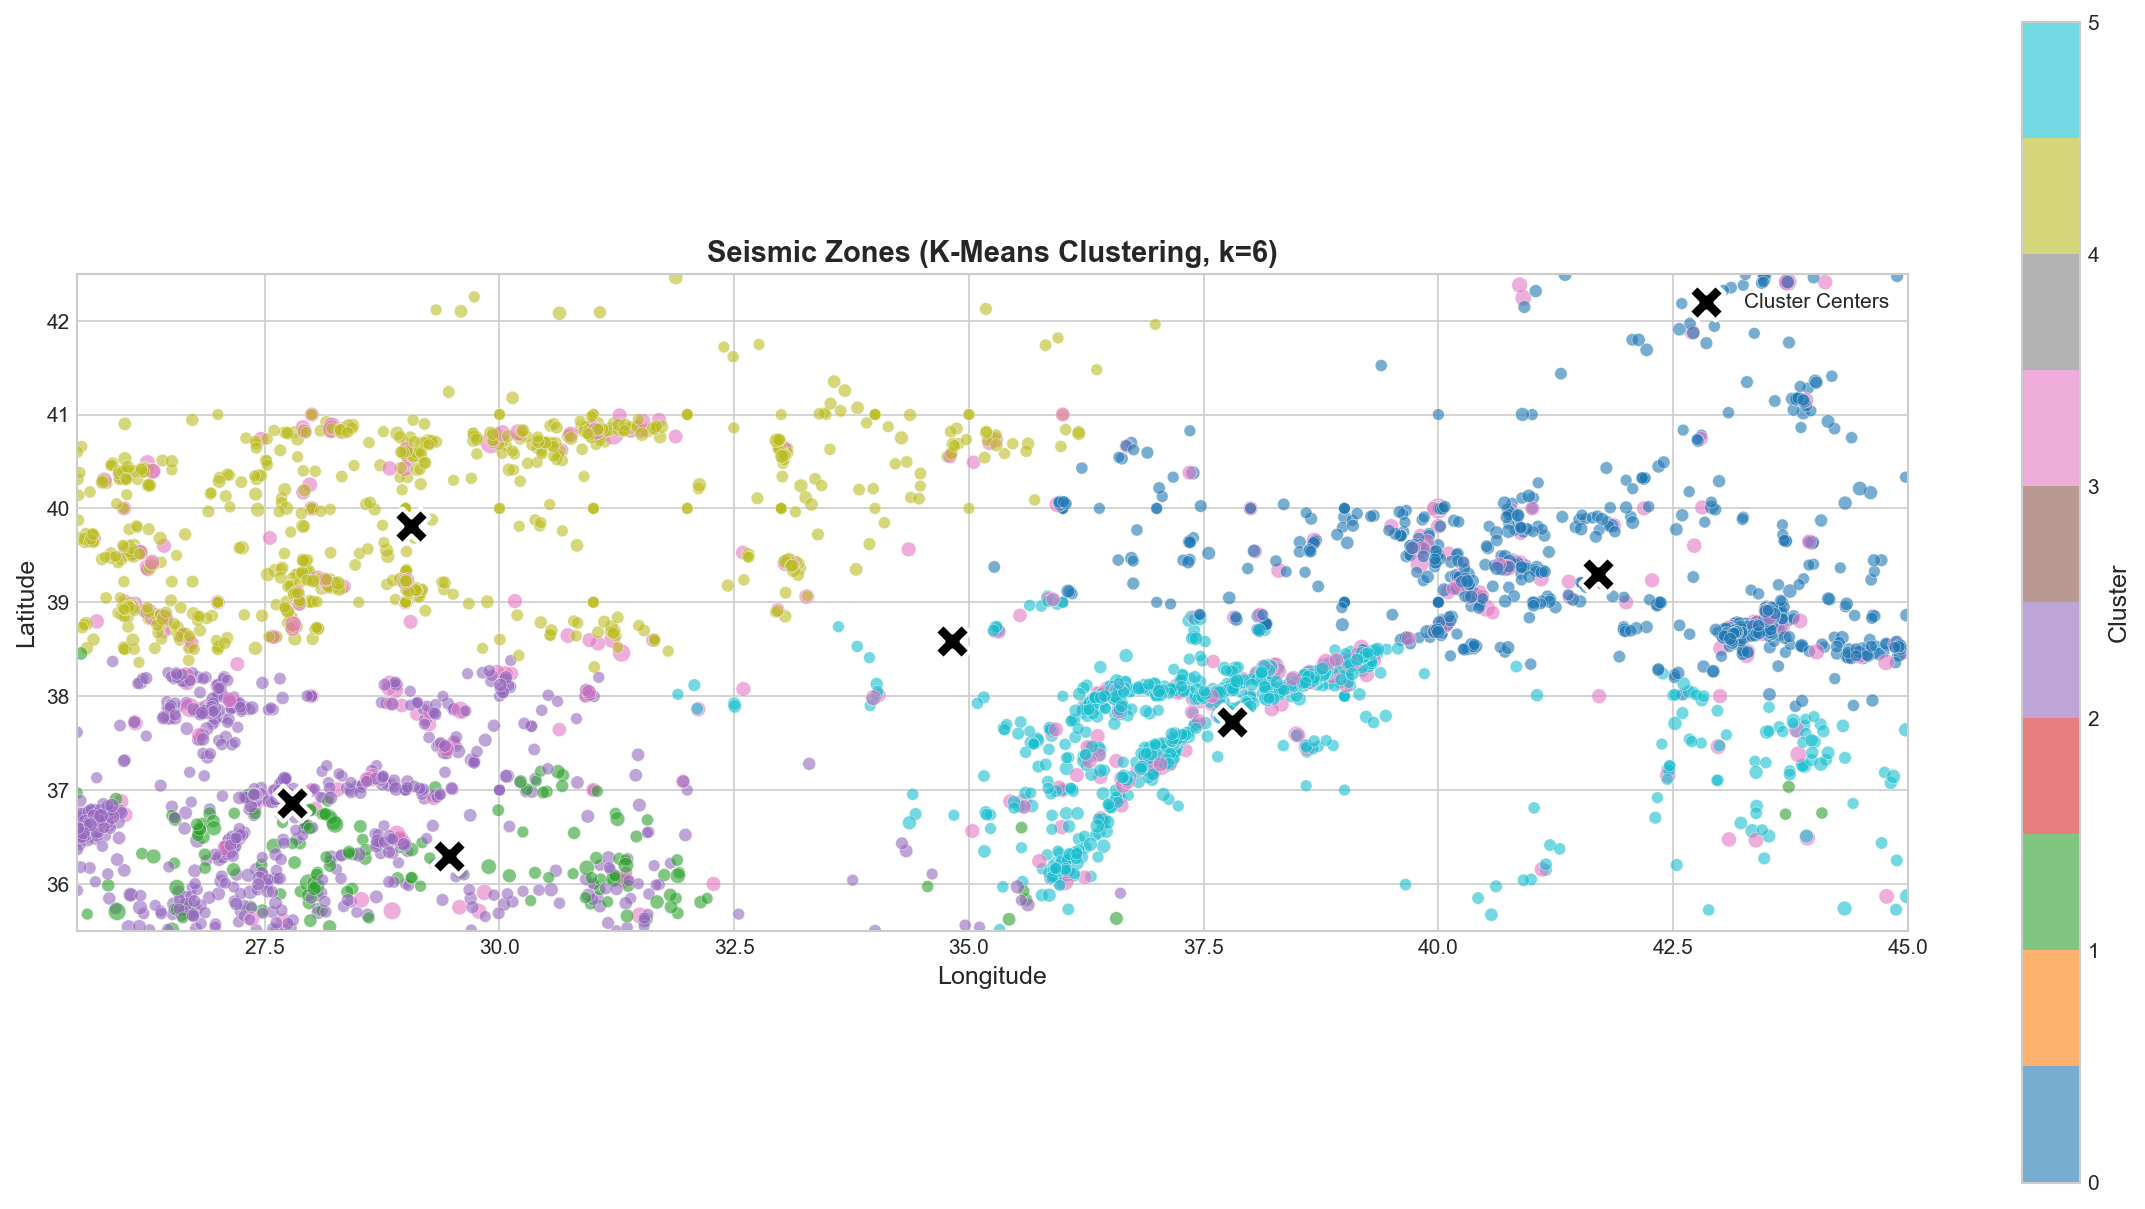

In [6]:
# Map clusters
fig, ax = plt.subplots(figsize=(16, 10))
ax = create_turkey_basemap(ax, f'Seismic Zones (K-Means Clustering, k={k})')

scatter = ax.scatter(features['longitude'], features['latitude'],
                     c=features['cluster'], s=features['magnitude']**2 * 2,
                     cmap=CLUSTER_CMAP, alpha=0.6, edgecolors='white', linewidth=0.3)

# Plot cluster centers
centers = scaler.inverse_transform(kmeans.cluster_centers_)
ax.scatter(centers[:, 1], centers[:, 0], c='black', marker='X', s=300, 
           edgecolors='white', linewidth=2, label='Cluster Centers', zorder=10)

plt.colorbar(scatter, ax=ax, label='Cluster', shrink=0.8)
ax.legend(loc='upper right')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'cluster_map.png'), dpi=150, bbox_inches='tight')
plt.show()

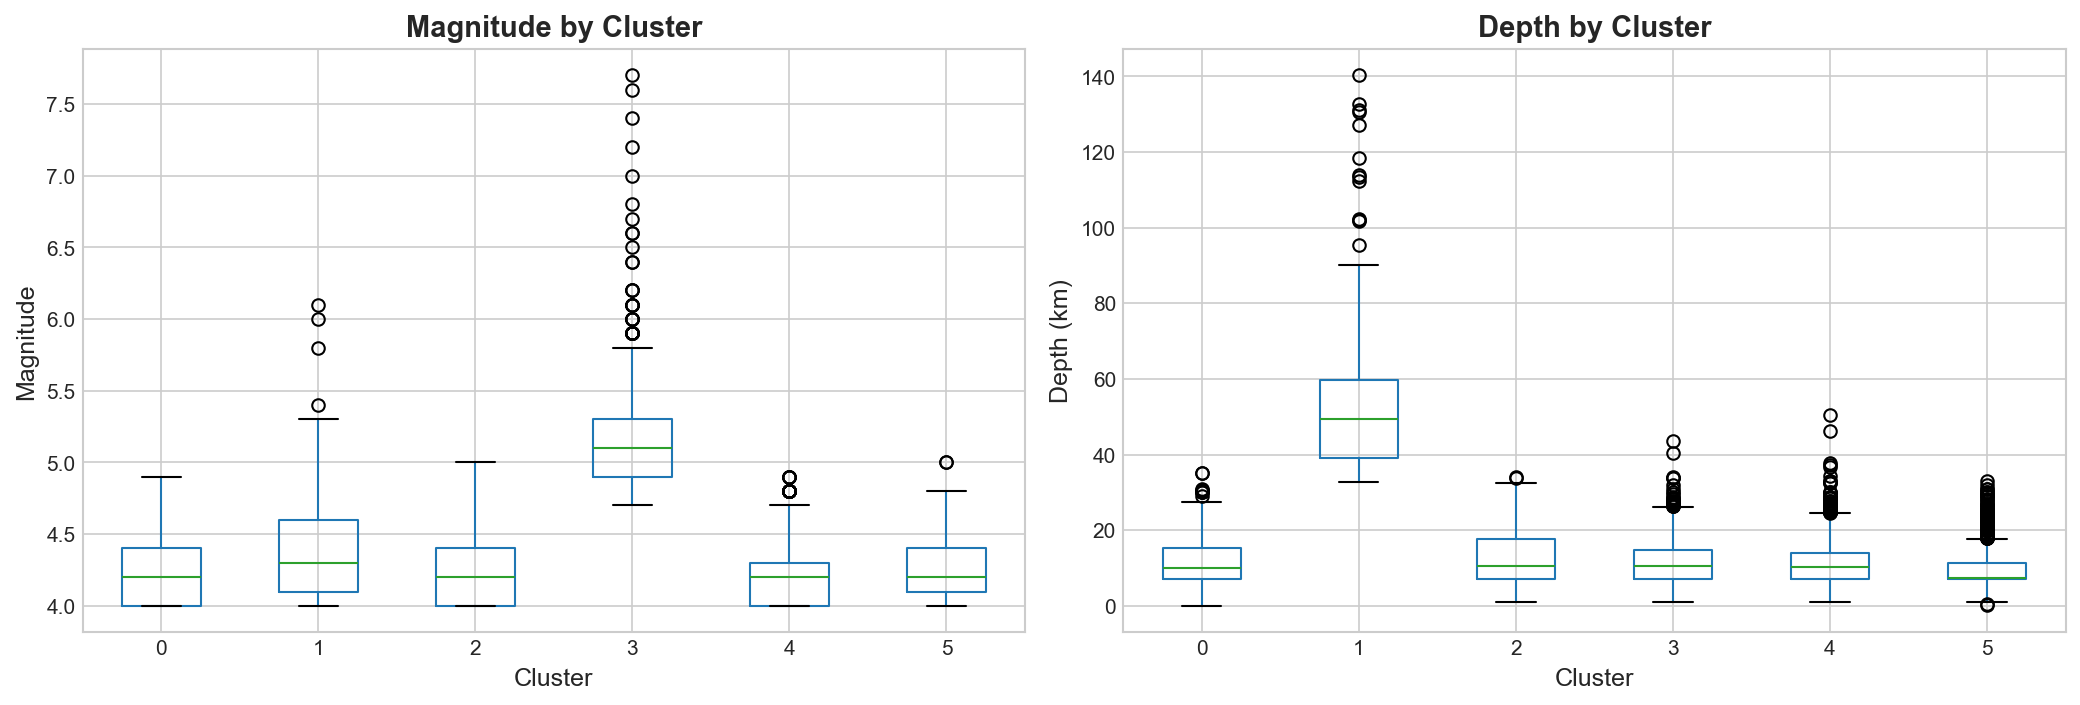

In [7]:
# Cluster characteristics
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = axes[0]
features.boxplot(column='magnitude', by='cluster', ax=ax1)
ax1.set_xlabel('Cluster')
ax1.set_ylabel('Magnitude')
ax1.set_title('Magnitude by Cluster', fontweight='bold')
plt.suptitle('')

ax2 = axes[1]
features.boxplot(column='depth', by='cluster', ax=ax2)
ax2.set_xlabel('Cluster')
ax2.set_ylabel('Depth (km)')
ax2.set_title('Depth by Cluster', fontweight='bold')
plt.suptitle('')

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, 'cluster_characteristics.png'), dpi=150, bbox_inches='tight')
plt.show()

In [8]:
# Save results
cluster_stats.to_csv(os.path.join(TABLES_PATH, 'cluster_analysis.csv'))

# Save cluster labels
earthquakes_with_clusters = earthquakes.loc[features.index].copy()
earthquakes_with_clusters['cluster'] = features['cluster'].values
earthquakes_with_clusters.to_csv(os.path.join(DATA_PROCESSED, 'earthquakes_clustered.csv'), index=False)

print(f"Results saved to: {os.path.join(TABLES_PATH, 'cluster_analysis.csv')}")
print(f"Clustered data saved to: {os.path.join(DATA_PROCESSED, 'earthquakes_clustered.csv')}")

Results saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/reports/tables/cluster_analysis.csv
Clustered data saved to: /Users/boraesen/Desktop/Semester 7/Stat495/stat495project/data/processed/earthquakes_clustered.csv
